# Politeness

**Inspired by:** _Yoon, E. J., Tessler, M. H., Goodman, N. D., & Frank, M. C. (2020). Polite speech emerges from competing social goals. Open Mind, 4, 71-87._

## Step 1: Imports

In [1]:
from memo import memo
import jax
import jax.numpy as np
from enum import IntEnum, auto

## Step 2: Define data types

In [2]:
S = np.arange(4)  # true world states (number of hearts)

class W(IntEnum):  # possible utterances
    terrible = auto(0)
    not_amazing = auto()
    not_terrible = auto()
    amazing = auto()

## Step 3: Define helper functions - assumptions and priors

In [3]:
@jax.jit
def V(s):  # value to listener
    return s  # linear in s

@jax.jit
def state_prior(s):
    return 1  # uninformative state prior

@jax.jit
def L(w, s):  # literal likelihood L(w | s)
    return np.array([  # "soft semantics"
        [1, 0.5, 0, 0],  # terrible
        [1, 1, 1, 0],  # not amazing
        [0, 1, 1, 1],  # not terrible
        [0, 0, 0.5, 1],  # amazing
    ])[w, s]

## Step 4: Implement memo model

In [4]:
@memo
def S1[s: S, w: W](alpha, phi):
    speaker: knows(s)
    speaker: thinks[
        listener: thinks[
            speaker: given(s in S, wpp=state_prior(s)),
            speaker: chooses(w in W, wpp=L(w, s))
        ]
    ]
    speaker: chooses(w in W, wpp=exp(alpha * imagine[
        listener: observes [speaker.w] is w,
        listener: knows(s),
        (
            phi * listener[ log(Pr[speaker.s == s]) ] +  # U_inf = listener's surprisal
            (1 - phi) * listener[ E[ V(speaker.s) ] ]    # U_soc = listener's EU
        )
    ]))
    return Pr[speaker.w == w]

## Step 5: Run memo model and visualize results

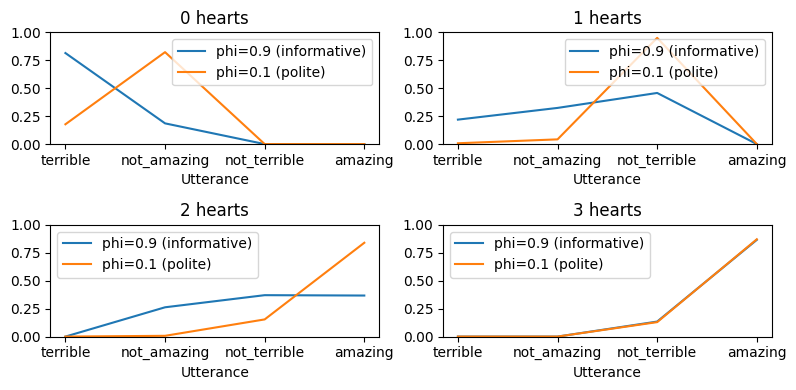

In [5]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8, 4))
for s in S:
    plt.subplot(2, 2, int(s + 1))
    plt.plot(S1(alpha=3.0, phi=0.9)[s], label='phi=0.9 (informative)')
    plt.plot(S1(alpha=3.0, phi=0.1)[s], label='phi=0.1 (polite)')
    plt.xticks(W, [w.name for w in W])
    plt.xlabel('Utterance')
    plt.ylim(0, 1)
    plt.legend()
    plt.title(f'{s} hearts')
plt.tight_layout()